# Bayesian Optimization

## Bayesian Optimization for hyperparameter optimization in Machine Learning

Final project for the *Bayesian Optimization* course. 

David Revillas - `drevillas@pm.me`

## 1. Introduction

The objective of this project is to implement the hyperparamenter optimization for any Machine Learning technique, using Bayesian Optimization libraries such as [Ax](https://ax.dev), built on top of [GPyTorch](https://github.com/cornellius-gp/gpytorch) and [BoTorch](https://botorch.org/). 

For the analysis, a regression problem is propsed and the next models will be tested: [LighGBM](https://github.com/Microsoft/LightGBM), [Support Vector Machine for regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) and a simple MLP.

All of them will be measured with the mean squared error metric, comparing the default tuned model with the optimized one for each dataset.

First, start by importing all the required packages

In [1]:
import numpy as np

# Datasets
import pandas as pd
from sklearn.datasets import load_boston, fetch_california_housing

# Models
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
import tensorflow as tf

# Scikit-learn subclassing
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split

# Plotting
from matplotlib import pyplot as plt

# Optimization
import torch
from ax import optimize

# Plotting
from ax.plot.trace import optimization_trace_single_method

In [2]:
# Reproducibility
torch.manual_seed(12345)
dtype = torch.float
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


## 2. *Boston dataset*

The dataset used as commented is the [Boston house prices](https://scikit-learn.org/stable/datasets/index.html#boston-house-prices-dataset) *toy dataset*. However, the  [California housing](https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset) *real world* dataset has been also taken into account, but it has not been possible to finish due to very long run times.

### 2.1 Dataset info

1. Title: Boston Housing Data

2. Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.
   (b) Creator:  Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the  demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978.
   (c) Date: July 7, 1993

3. Past Usage:
    -  Used in Belsley, Kuh & Welsch, 'Regression diagnostics ...', Wiley,  1980. N.B. Various transformations are used in the table on pages 244-261.
    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.
    

4. Relevant Information:

   Concerns housing values in suburbs of Boston.   

5. Number of Instances: 506

6. Number of Attributes: 13 continuous attributes (including "class" attribute "MEDV"), 1 binary-valued attribute.

7. Attribute Information:

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10. TAX      full-value property-tax rate per \$10,000
    11. PTRATIO  pupil-teacher ratio by town
    12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks  by town
    13. LSTAT    % lower status of the population
    14. MEDV     Median value of owner-occupied homes in \$1000's


8. Missing Attribute Values:  None.

### 2.2 Prepare dataset

In [3]:
# Load Boston dataset
X, y = load_boston(return_X_y=True)

boston = pd.DataFrame(
    np.concatenate([X, y.reshape(len(y), -1)], axis=1), 
    columns=["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]
)
boston.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

In [4]:
# Remove comment to try out California dataset
# WARNING: It will take too much time

# X, y = fetch_california_housing(return_X_y=True, as_frame=True)
# california = pd.concat([X, y], axis=1)
# y = y.values
# california

70% of the dataset is used to train the models and 30% to evaluate them.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 2.3 Default models

#### 2.3.1 Defining default models

Instantiate LGBM Regressor

In [6]:
default_lgbm = LGBMRegressor()
default_lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Instantiate SVR

In [7]:
default_svr = SVR()
default_svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Instantiate MLP subclassing *sklearn* regressor base class [KerasRegressor](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasRegressor).

In [8]:
def build_mlp():
    mlp = tf.keras.models.Sequential()

    mlp.add(tf.keras.layers.Dense(128, input_shape=(13, ), activation='relu', name='dense_1'))
    mlp.add(tf.keras.layers.Dense(64, activation='relu', name='dense_2'))
    mlp.add(tf.keras.layers.Dense(1, activation='linear', name='dense_output'))

    mlp.compile(optimizer='adam', loss='mse')
    mlp.summary()
    
    return mlp
    
default_mlp = KerasRegressor(build_fn=build_mlp, epochs=100, batch_size=32, verbose=0)

#### 2.3.2 Train and evaluate defaults models

As selected models implements `sklearn`'s base class, training methods are callable by the same function `fit()`. Also, to get more accurate error a 10-fold [cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) is permformed.

In [9]:
%%time
default_models = [
    ("LGBM", LGBMRegressor()), 
    ("SVR", SVR()), 
    ("MLP", KerasRegressor(build_fn=build_mlp, epochs=100, batch_size=10, verbose=3))
]
scores = {"LGBM": None, "SVR": None, "MLP": None}

for name, model in default_models:
    scores[name] = cross_val_score(model, 
                                   X_train, 
                                   y_train.ravel(), 
                                   cv=10, 
                                   scoring=make_scorer(mean_squared_error), 
                                   n_jobs=-1)
    print(f"{name} MSE: %0.2f (+/- %0.2f)" % (scores[name].mean(), scores[name].std() * 2))

LGBM MSE: 14.65 (+/- 16.50)
SVR MSE: 73.01 (+/- 39.72)
MLP MSE: 26.49 (+/- 14.45)
CPU times: user 161 ms, sys: 30.2 ms, total: 191 ms
Wall time: 13.1 s


#### 2.3.3 Plotting predictions

Training again the default models with houldout in order to do some forecasts:

In [10]:
models = [
    ("LGBM", default_lgbm), 
    ("SVR", default_svr),
    ("MLP", default_mlp)
]
for name, model in models:
    print(f"Training {name}...")
    model.fit(X_train, y_train)

Training LGBM...
Training SVR...
Training MLP...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_output (Dense)         (None, 1)                 65        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________


Get forecasts

[]

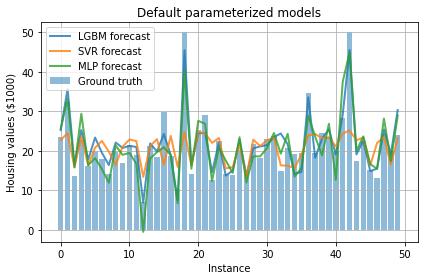

In [15]:
# fig = plt.figure(figsize=(15, 7))
items = 50
x = np.arange(items)

plt.bar(x, y_test[:items], label="Ground truth", alpha=0.5)
y
for i, (name, model) in enumerate(models):
    y_pred = model.predict(X_test[:items])
    
#     plt.bar(x, y_pred, label=f"{name} forecast", alpha=0.2)
#     plt.scatter(x, y_pred, label=f"{name} forecast", alpha=0.6, s=5)
    plt.plot(x, y_pred, label=f"{name} forecast", alpha=0.8, lw=2)

plt.title(f"Default parameterized models")
plt.xlabel("Instance")
plt.ylabel("Housing values (\$1000)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.plot()

[]

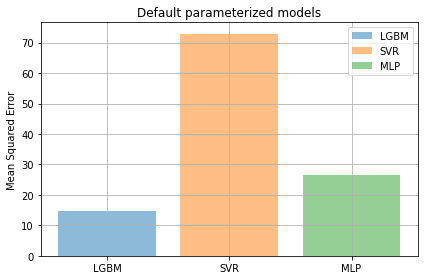

In [14]:
fig = plt.figure()

for i, (name, model) in enumerate(models):
    y_pred = model.predict(X_test)    
    plt.bar(name, abs(scores[name].mean()), label=name, alpha=0.5)

plt.title(f"Default parameterized models")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.legend()
plt.tight_layout()
plt.plot()

### 2.4 Bayesian Optimization

To start with a bayesian optimization process of hyperparameters, it is necessary to define the parameters to tune for each model and the evaluation function.

#### 2.4.1 SVR

Define [SVR parameters](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) to tune:
- `kernel`: Specifies the kernel type, $\{linear, poly, rbf, sigmoid, precomputed \}$.
- `C`: Regularization parameter, $\mathbb{R} \in (0, 10]$.
- `tol`:, Tolerance for stopping criterion, $\mathbb{R} \in (0, 1]$.

In [16]:
svr_bo_params = [
    {"name": 'kernel', "type": "choice",  "values": ['linear', 'poly', 'rbf', 'sigmoid'], 'value_type': 'str'},
    {"name": 'C', "type": "range",  "bounds": [10e-5, 10], 'value_type': 'float'},
    {"name": 'tol', "type": "range",  "bounds": [10e-5, 1], 'value_type': 'float'}
]

And define evaluation function as:

In [17]:
def evaluate_SVR(parameterization):
    model = SVR(**parameterization)
    
    # Cross validation
    score = cross_val_score(model, 
                                X_train, 
                                y_train.ravel(), 
                                cv=10, 
                                scoring=make_scorer(mean_squared_error),
                                n_jobs=-1)
    
    return np.mean(score)

##### 2.4.1.1 Optimize parameters

In [18]:
best_svr_parameters, best_svr_values, svr_experiment, svr_model = optimize(
    parameters=svr_bo_params,
    evaluation_function=evaluate_SVR,
    minimize=True,
    total_trials=50,
    random_seed=42
)

[INFO 12-19 14:06:54] ax.modelbridge.dispatch_utils: Using Sobol generation strategy.
[INFO 12-19 14:06:54] ax.service.managed_loop: Started full optimization with 50 steps.
[INFO 12-19 14:06:54] ax.service.managed_loop: Running optimization trial 1...
[INFO 12-19 14:06:55] ax.service.managed_loop: Running optimization trial 2...
[INFO 12-19 14:06:55] ax.service.managed_loop: Running optimization trial 3...
[INFO 12-19 14:06:55] ax.service.managed_loop: Running optimization trial 4...
[INFO 12-19 14:06:57] ax.service.managed_loop: Running optimization trial 5...
[INFO 12-19 14:06:57] ax.service.managed_loop: Running optimization trial 6...
[INFO 12-19 14:06:57] ax.service.managed_loop: Running optimization trial 7...
[INFO 12-19 14:07:03] ax.service.managed_loop: Running optimization trial 8...
[INFO 12-19 14:07:11] ax.service.managed_loop: Running optimization trial 9...
[INFO 12-19 14:07:11] ax.service.managed_loop: Running optimization trial 10...
[INFO 12-19 14:07:11] ax.service.ma

In [19]:
best_svr_parameters, best_svr_values

({'C': 0.3560829272555187, 'tol': 0.7502622092821635, 'kernel': 'linear'},
 ({'objective': 27.29766986765685}, {'objective': {'objective': 0.0}}))

##### 2.4.1.2 Plot optimization

In [20]:
best_svr_objectives = np.array([trial.objective_mean for trial in svr_experiment.trials.values()])

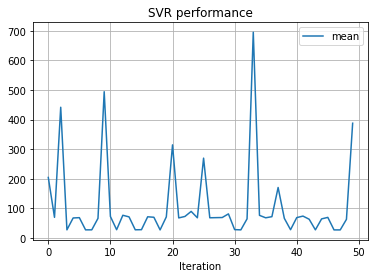

In [21]:
plt.plot(best_svr_objectives, label="mean")
plt.grid(True)
plt.title("SVR performance")
plt.xlabel("Iteration")
plt.legend()
plt.show()

##### 2.4.1.3 Fit optimized SVR

In [22]:
optimized_svr = SVR(**best_svr_parameters)
optimized_svr.fit(X_train, y_train)

SVR(C=0.3560829272555187, kernel='linear', tol=0.7502622092821635)

In [23]:
models = [("Optimized SVR", optimized_svr), ("Default SVR", default_svr)]

[]

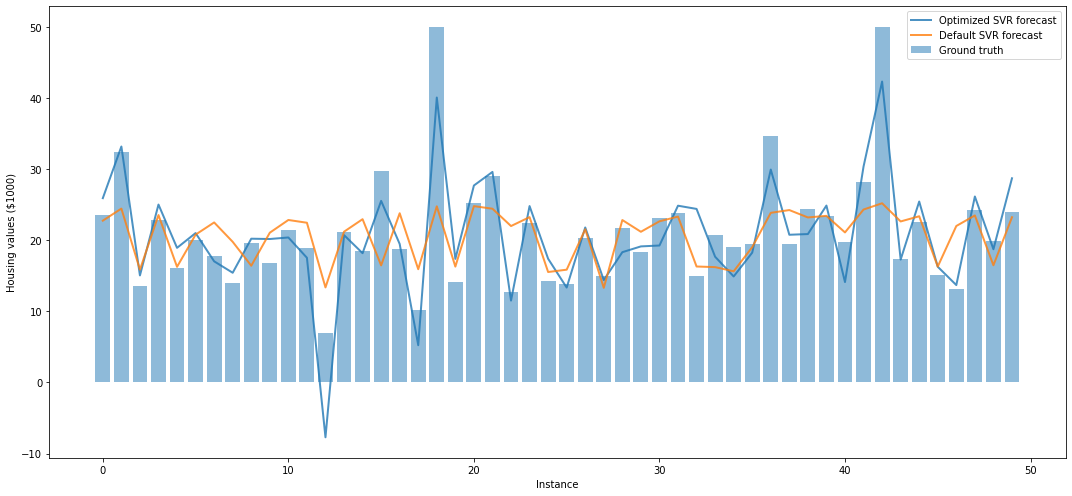

In [24]:
fig = plt.figure(figsize=(15, 7))
items = 50
x = np.arange(items)

plt.bar(x, y_test[:items], label="Ground truth", alpha=0.5)
y
for i, (name, model) in enumerate(models):
    y_pred = model.predict(X_test[:items])
    
#     plt.bar(x, y_pred, label=f"{name} forecast", alpha=0.2)
#     plt.scatter(x, y_pred, label=f"{name} forecast", alpha=0.6, s=5)
    plt.plot(x, y_pred, label=f"{name} forecast", alpha=0.8, lw=2)
    
plt.xlabel("Instance")
plt.ylabel("Housing values (\$1000)")
plt.legend()
plt.tight_layout()
plt.plot()

[]

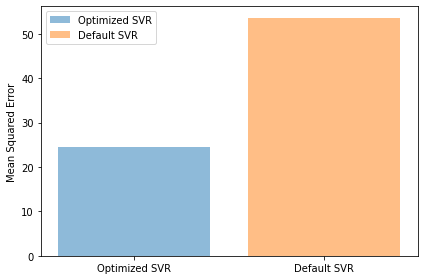

In [25]:
fig = plt.figure()

for i, (name, model) in enumerate(models):
    y_pred = model.predict(X_test)    
    score = mean_squared_error(y_test, y_pred)
    plt.bar(name, score, label=name, alpha=0.5)
    
plt.ylabel("Mean Squared Error")
# plt.ylabel("Housing values (\$1000)")
plt.legend()
plt.tight_layout()
plt.plot()

#### 2.4.2 LightGBM

Define LGBM parameters to tune:
- [Learning rate](https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst#learning_rate): $\mathbb{R} \in (0, 1]$.
- [Max depth](https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst#max_depth): limits the max depth for tree model. If less or equal than 0, there is no limit depth. $\mathbb{Z} \in [0, 200]$.
- [Min_child_samples](https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst#min_data_in_leaf):, minimal number of data in one leaf. $\mathbb{Z} \in [0, 200]$.
- [Num_leaves](https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst#num_leaves): max number of leaves in one tree. $\mathbb{Z} \in [2, 5]$

In [26]:
lgbm_bo_params = [
    {"name": 'learning_rate', "type": "range",  "bounds": [10e-5, 1.], 'value_type': 'float'},
    {"name": 'max_depth', "type": "range",  "bounds": [0, 200], 'value_type': 'int'},
    {"name": 'min_child_samples', "type": "range", "bounds": [0, 200], 'value_type': 'int'},
    {"name": 'num_leaves', "type": "range",  "bounds": [2, 5], 'value_type': 'int'},
]

And define evaluation function as:

In [27]:
def evaluate_LGBM(parameterization):
    model = LGBMRegressor(**parameterization)
    
    # Cross validation
    score = cross_val_score(model, 
                                X_train, 
                                y_train.ravel(), 
                                cv=10, 
                                scoring=make_scorer(mean_squared_error),
                                n_jobs=-1)
    
    return np.mean(score)

##### 2.4.2.1 Optimize parameters

In [28]:
best_lgbm_parameters, best_lgbm_values, lgbm_experiment, lgbm_model = optimize(
    parameters=lgbm_bo_params,
    evaluation_function=evaluate_LGBM,
    minimize=True,
    total_trials=50,
    random_seed=42
)

[INFO 12-19 14:22:38] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 12-19 14:22:38] ax.service.managed_loop: Started full optimization with 50 steps.
[INFO 12-19 14:22:38] ax.service.managed_loop: Running optimization trial 1...
[INFO 12-19 14:22:39] ax.service.managed_loop: Running optimization trial 2...
[INFO 12-19 14:22:39] ax.service.managed_loop: Running optimization trial 3...
[INFO 12-19 14:22:39] ax.service.managed_loop: Running optimization trial 4...
[INFO 12-19 14:22:39] ax.service.managed_loop: Running optimization trial 5...
[INFO 12-19 14:22:39] ax.service.managed_loop: Running optimization trial 6...
[INFO 12-19 14:22:40] ax.service.managed_loop: Running optimization trial 7...
[INFO 12-19 14:22:40] ax.service.managed_loop: Running optimization trial 8...
[INFO 12-19 

In [29]:
best_lgbm_parameters, best_lgbm_values

({'learning_rate': 0.22294806812969045,
  'max_depth': 36,
  'min_child_samples': 8,
  'num_leaves': 4},
 ({'objective': 12.40661851920916},
  {'objective': {'objective': 4.016221070084862e-05}}))

##### 2.4.2.2 Plot optimization

In [30]:
best_objectives = np.array([trial.objective_mean for trial in lgbm_experiment.trials.values()])

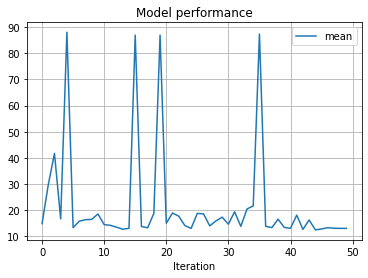

In [31]:
plt.plot(best_objectives, label="mean")
plt.grid(True)
plt.title("Model performance")
plt.xlabel("Iteration")
plt.legend()
plt.show()

##### 2.4.2.3 Fit optimized LGBM

In [32]:
optimized_lgbm = LGBMRegressor(**best_lgbm_parameters)
optimized_lgbm.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.22294806812969045, max_depth=36,
              min_child_samples=8, num_leaves=4)

In [33]:
models = [("Optimized LGBM", optimized_lgbm), ("Default LGBM", default_lgbm)]

[]

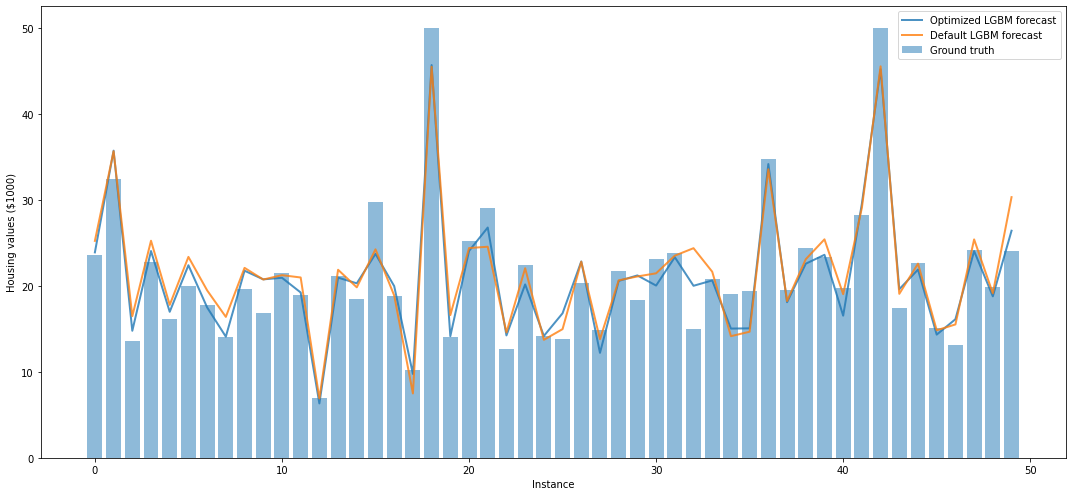

In [34]:
fig = plt.figure(figsize=(15, 7))
items = 50
x = np.arange(items)

plt.bar(x, y_test[:items], label="Ground truth", alpha=0.5)
y
for i, (name, model) in enumerate(models):
    y_pred = model.predict(X_test[:items])
    
#     plt.bar(x, y_pred, label=f"{name} forecast", alpha=0.2)
#     plt.scatter(x, y_pred, label=f"{name} forecast", alpha=0.6, s=5)
    plt.plot(x, y_pred, label=f"{name} forecast", alpha=0.8, lw=2)
    
plt.xlabel("Instance")
plt.ylabel("Housing values (\$1000)")
plt.legend()
plt.tight_layout()
plt.plot()

[]

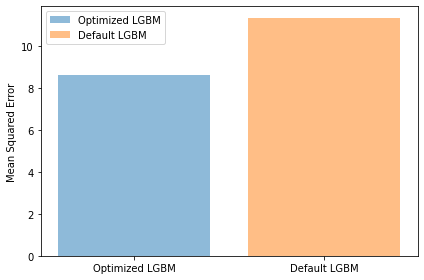

In [35]:
fig = plt.figure()

for i, (name, model) in enumerate(models):
    y_pred = model.predict(X_test)    
    score = mean_squared_error(y_test, y_pred)
    plt.bar(name, score, label=name, alpha=0.5)
    
plt.ylabel("Mean Squared Error")
# plt.ylabel("Housing values (\$1000)")
plt.legend()
plt.tight_layout()
plt.plot()

#### 2.4.3 Multi Layer Perceptron

Define MLP parameters to tune:
- [Learning rate](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam): ADAM optimizer learning rate, $\mathbb{R} \in (0, 0.0001]$.
- Layers: number of hidden layers to add, $\mathbb{Z} \in [1, 6]$.
- Neurons: Neurons of the first Dense layer, $\mathbb{Z} \in [64, 2048]$

In [39]:
mlp_bo_params = [
    {"name": 'learning_rate', "type": "range",  "bounds": [10e-7, 10e-5], 'value_type': 'float'},
    {"name": 'layers', "type": "range",  "bounds": [1, 6], 'value_type': 'int'},
    {"name": 'neurons', "type": "range",  "bounds": [64, 2048], 'value_type': 'int'},
]

And define evaluation function as:

In [40]:
def evaluate_MLP(parameterization):
    # IT SEEMS TO WORK ONLY DEFINING THE BUILD FUNCTION AS FOLLOWS
    def build_parameterized_mlp():
        neurons = parameterization['neurons']
        layers = parameterization['layers']
        
        mlp = tf.keras.models.Sequential()
        mlp.add(tf.keras.layers.Dense(neurons, input_shape=(13, ), activation='relu', name='dense_1'))

        for i in range(1, layers):
            mlp.add(tf.keras.layers.Dense(neurons//(2*i), activation='relu', name=f'hidden_{i}'))

        mlp.add(tf.keras.layers.Dense(1, activation='linear', name='dense_output'))

        mlp.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=parameterization['learning_rate']), 
            loss='mse')
        
        return mlp
    
    model = KerasRegressor(build_fn=build_parameterized_mlp, 
                           epochs=100, batch_size=32, verbose=0)

    
    # Cross validation
    score = cross_val_score(model, 
                                X_train, 
                                y_train.ravel(), 
                                cv=10, 
                                scoring=make_scorer(mean_squared_error),
                                n_jobs=-1)
    
    return np.mean(score)

##### 2.4.3.1 Optimize parameters

In [41]:
best_mlp_parameters, best_mlp_values, mlp_experiment, mlp_model = optimize(
    parameters=mlp_bo_params,
    evaluation_function=evaluate_MLP,
    minimize=True,
    total_trials=25,
    random_seed=42
)

[INFO 12-19 14:35:53] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 12-19 14:35:53] ax.service.managed_loop: Started full optimization with 25 steps.
[INFO 12-19 14:35:53] ax.service.managed_loop: Running optimization trial 1...
[INFO 12-19 14:36:35] ax.service.managed_loop: Running optimization trial 2...
[INFO 12-19 14:36:42] ax.service.managed_loop: Running optimization trial 3...
[INFO 12-19 14:37:30] ax.service.managed_loop: Running optimization trial 4...
[INFO 12-19 14:37:49] ax.service.managed_loop: Running optimization trial 5...
[INFO 12-19 14:40:16] ax.service.managed_loop: Running optimization trial 6...
[INFO 12-19 14:41:56] ax.service.managed_loop: Running optimization trial 7...
[INFO 12-19 14:42:28] ax.service.managed_loop: Running optimization trial 8...
[INFO 12-19 

In [42]:
best_mlp_parameters, best_mlp_values

({'learning_rate': 7.03079910715438e-05, 'layers': 6, 'neurons': 1531},
 ({'objective': 24.444041363486047},
  {'objective': {'objective': 3.13898312287716e-06}}))

In [215]:
{'learning_rate': 9.715192431250805e-05, 'layers': 6, 'neurons': 1073}

##### 2.4.3.2 Plot optimization

In [43]:
best_objectives = np.array([trial.objective_mean for trial in mlp_experiment.trials.values()])

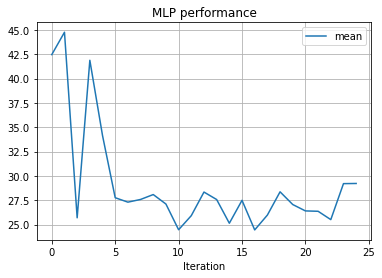

In [44]:
plt.plot(best_objectives, label="mean")
plt.grid(True)
plt.title("MLP performance")
plt.xlabel("Iteration")
plt.legend()
plt.show()

##### 2.4.3.3 Fit optimized MLP

In [45]:
def build_parameterized_mlp(learning_rate, neurons, layers):
    mlp = tf.keras.models.Sequential()
    mlp.add(tf.keras.layers.Dense(neurons, input_shape=(13, ), activation='relu', name='dense_1'))

    for i in range(1, layers):
        mlp.add(tf.keras.layers.Dense(neurons//(2*i), activation='relu', name=f'hidden_{i}'))

    mlp.add(tf.keras.layers.Dense(1, activation='linear', name='dense_output'))

    mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    return mlp

In [46]:
optimized_mlp = build_parameterized_mlp(**best_mlp_parameters)
print(optimized_mlp.summary())
optimized_mlp.fit(X_train, y_train, epochs=100, verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1531)              21434     
_________________________________________________________________
hidden_1 (Dense)             (None, 765)               1171980   
_________________________________________________________________
hidden_2 (Dense)             (None, 382)               292612    
_________________________________________________________________
hidden_3 (Dense)             (None, 255)               97665     
_________________________________________________________________
hidden_4 (Dense)             (None, 191)               48896     
_________________________________________________________________
hidden_5 (Dense)             (None, 153)               29376     
_________________________________________________________________
dense_output (Dense)         (None, 1)                

In [47]:
models = [("Optimized MLP", optimized_mlp), ("Default MLP", default_mlp)]

[]

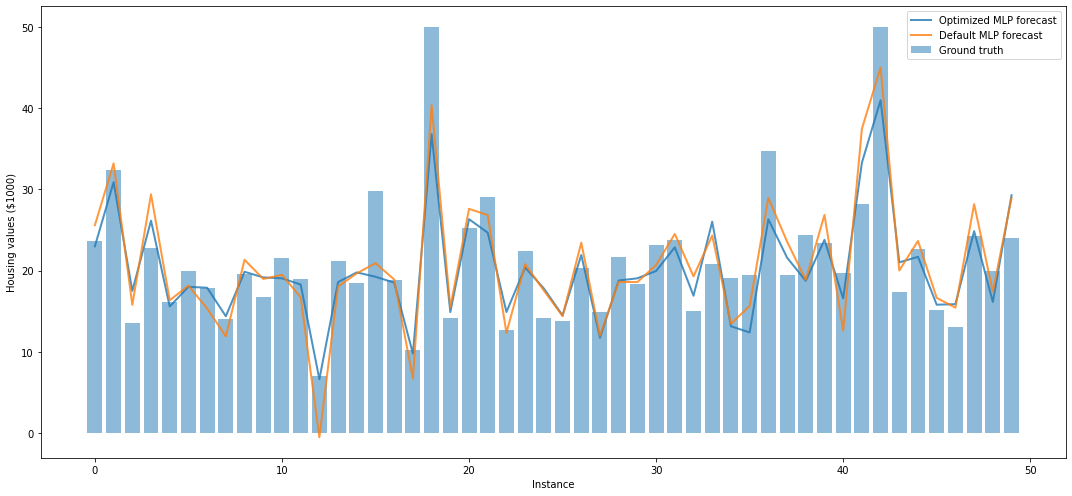

In [48]:
fig = plt.figure(figsize=(15, 7))
items = 50
x = np.arange(items)

plt.bar(x, y_test[:items], label="Ground truth", alpha=0.5)
y
for i, (name, model) in enumerate(models):
    y_pred = model.predict(X_test[:items])
    
#     plt.bar(x, y_pred, label=f"{name} forecast", alpha=0.2)
#     plt.scatter(x, y_pred, label=f"{name} forecast", alpha=0.6, s=5)
    plt.plot(x, y_pred, label=f"{name} forecast", alpha=0.8, lw=2)
    
plt.xlabel("Instance")
plt.ylabel("Housing values (\$1000)")
plt.legend()
plt.tight_layout()
plt.plot()

[]

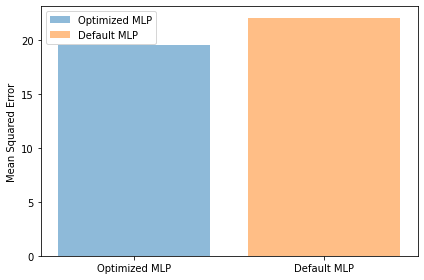

In [49]:
fig = plt.figure()

for i, (name, model) in enumerate(models):
    y_pred = model.predict(X_test)    
    score = mean_squared_error(y_test, y_pred)
    plt.bar(name, score, label=name, alpha=0.5)
    
plt.ylabel("Mean Squared Error")
# plt.ylabel("Housing values (\$1000)")
plt.legend()
plt.tight_layout()
plt.plot()

[]

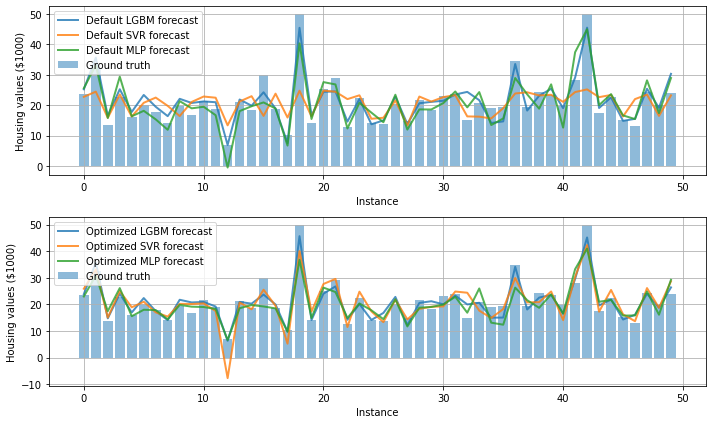

In [60]:
items = 50
x = np.arange(items)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 6))

models = [
    ("Optimized LGBM", optimized_lgbm), ("Default LGBM", default_lgbm),
    ("Optimized SVR", optimized_svr), ("Default SVR", default_svr),
    ("Optimized MLP", optimized_mlp), ("Default MLP", default_mlp)
]

ax0.bar(x, y_test[:items], label="Ground truth", alpha=0.5)
ax1.bar(x, y_test[:items], label="Ground truth", alpha=0.5)

for i, (name, model) in enumerate(models):
    if "Opt" in name: 
        y_pred = model.predict(X_test[:items])
        ax1.plot(x, y_pred, label=f"{name} forecast", alpha=0.8, lw=2)
    if "Def" in name: 
        y_pred = model.predict(X_test[:items])
        ax0.plot(x, y_pred, label=f"{name} forecast", alpha=0.8, lw=2)

ax0.set_xlabel("Instance")
ax0.set_ylabel("Housing values (\$1000)")
ax0.legend(loc="upper left")
ax0.grid()

ax1.set_xlabel("Instance")
ax1.set_ylabel("Housing values (\$1000)")
ax1.legend(loc="upper left")
ax1.grid()



plt.tight_layout()
plt.plot()

[]

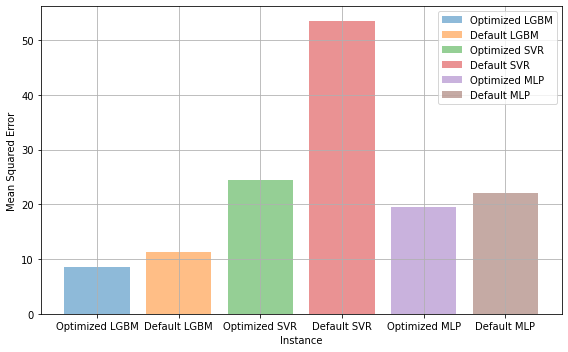

In [65]:
plt.figure(figsize=(8, 5))
for i, (name, model) in enumerate(models):
    y_pred = model.predict(X_test)    
    score = mean_squared_error(y_test, y_pred)
    plt.bar(name, score, label=name, alpha=0.5)

# plt.title(f"Optimized parameterized models")
plt.xlabel("Instance")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid()
plt.tight_layout()
plt.plot()